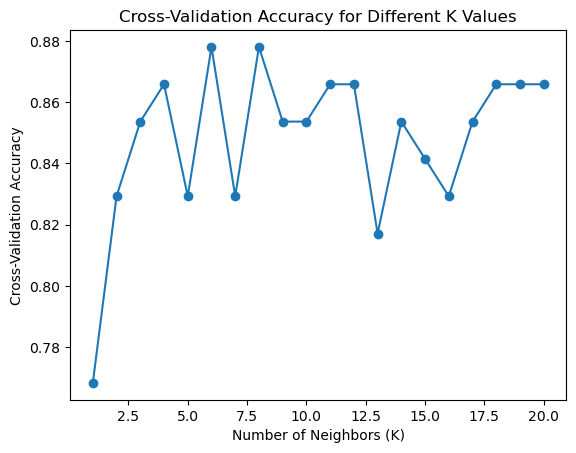

The optimal K value is: 6
Accuracy: 0.8780487804878049
Precision: 0.9
Recall: 0.7941176470588235
F1 Score: 0.84375


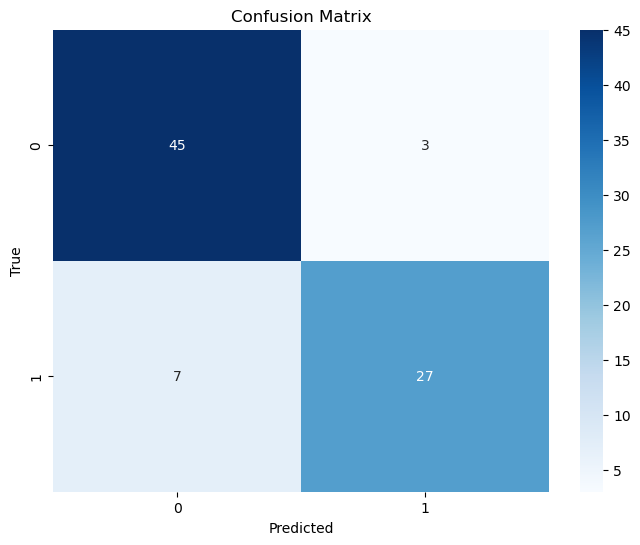

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_change_over_time(open_value, close_value):
    return (open_value - close_value) / open_value

def prepare_data(dataset):
    # Calculate Change over time
    dataset['ChangeOverTime'] = calculate_change_over_time(dataset['Open'], dataset['Close'])
    
    # Convert 'Up' and 'Down' labels to numeric values (1 and 0)
    dataset['Label'] = np.where(dataset['Label'] == 'up', 1, 0)
    
    # Extract features and labels
    X = dataset[['Open', 'ChangeOverTime']].values
    y = dataset['Label'].values
    
    return X, y

def manual_impute(X):
    # Impute missing values with the mean
    for i in range(X.shape[1]):
        mean_val = np.nanmean(X[:, i])
        X[:, i][np.isnan(X[:, i])] = mean_val
    
    return X

def manual_standardize(X):
    # Standardize numerical features
    for i in range(X.shape[1]):
        mean_val = np.mean(X[:, i])
        std_val = np.std(X[:, i])
        X[:, i] = (X[:, i] - mean_val) / std_val
    
    return X

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

    




def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    
    for test_point in X_test:
        # Calculate Euclidean distances between the test point and all training points
        distances = np.array([euclidean_distance(test_point, x) for x in X_train])
        
        # Get indices of the k-nearest neighbors
        neighbors_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k-nearest neighbors
        neighbors_labels = y_train[neighbors_indices]
        
        # Predict the label based on majority class
        predicted_label = np.bincount(neighbors_labels).argmax()
        
        predictions.append(predicted_label)
    
    return np.array(predictions)

def evaluate_results(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    
    # Confusion matrix
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    true_negative = np.sum((y_true == 0) & (y_pred == 0))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return accuracy, precision, recall, f1_score


# Load the dataset
df = pd.read_csv('/Users/pranatimareddy/Downloads/stocksdataset-1-2.csv')

# Imputing Null values in each column using Forward fill

df['Open'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)

# Prepare data
X, y = prepare_data(df)
# Impute missing values using the mean
#X = manual_impute(X)

# Standardize features
X = manual_standardize(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Find the optimal k value using cross-validation or other methods
# Here, we'll use a simple loop to test k values from 1 to 21
best_k = 1
best_accuracy = 0
k_values = list(range(1, 21))
cv_scores = []
for k in k_values:
    y_pred = knn_predict(X_train, y_train, X_test, k)
    accuracy, _, _, _ = evaluate_results(y_test, y_pred)
    cv_scores.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
plt.plot(k_values, cv_scores, marker='o')
plt.title('Cross-Validation Accuracy for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

# Choose the K with the highest cross-validation accuracy
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f'The optimal K value is: {best_k}')


# Make predictions using the optimal k value
y_pred = knn_predict(X_train, y_train, X_test, best_k)

# Evaluate the results
accuracy, precision, recall, f1_score = evaluate_results(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()